# Part 2: Emotion Recognition on Twitter

In [ ]:
# libraries import
import os
import re
import time
import math
import string
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import KeyedVectors
import helpers.data_mining_helpers as dmh

In [ ]:
# nltk library
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

In [ ]:
# sklearn library
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, classification_report

In [ ]:
# keras library
# preprocess
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# model
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding
from keras.layers import ReLU, Softmax, Dropout
from keras.callbacks import Callback
# RNN
from keras.layers import LSTM, Bidirectional, CuDNNLSTM, CuDNNGRU
# load model
from keras.models import model_from_json

Using TensorFlow backend.


### Split the whole training set into train/test set

In [ ]:
# import preprocessed training set
# dir path
dir_data = 'data/twitter'

f_whole_data_df = os.path.join(dir_data, 'data_df.pkl')

# read file and convert into pandas dataframe
whole_data_df = pd.read_pickle(f_whole_data_df)

In [ ]:
df = whole_data_df
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.15)

In [ ]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
train_df.to_pickle("data/twitter/train_df.pkl") 
test_df.to_pickle("data/twitter/test_df.pkl")

### import train/test/public test data

In [ ]:
# import preprocessed train/test/public test data
# dir path
dir_data = 'data/twitter'

f_train_df = os.path.join(dir_data, 'train_df.pkl')
f_test_df = os.path.join(dir_data, 'test_df.pkl')
f_public_test_df = os.path.join(dir_data, 'public_test_df.pkl')
f_sample_sub = os.path.join(dir_data, 'sampleSubmission.csv')

# read file and convert into pandas dataframe
train_df = pd.read_pickle(f_train_df)
test_df = pd.read_pickle(f_test_df)
public_test_df = pd.read_pickle(f_public_test_df)
sample_sub = pd.read_csv(f_sample_sub)

### Utils

In [ ]:
# utils
def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

In [ ]:
# csv_logger
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('logs/training_log.csv')

In [ ]:
# mean f1 score metrics
class Metrics(Callback):
    def on_train_begin(self, logs=None):
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = label_decode(label_encoder, y_pred)
        y_true = label_decode(label_encoder, self.validation_data[1])
        _val_f1 = f1_score(y_true, y_pred, average='macro')
        self.val_f1s.append(_val_f1)
        print(classification_report(y_true=y_true, y_pred=y_pred))
        print(_val_f1)
    
metrics = Metrics()

In [ ]:
# import custom emoji to adjectives about emotions mappings
emoji_dict = dmh.emoji
emojis = emoji_dict.keys()

In [ ]:
# import custom frequent name to adjectives about emotions mappings
frequent_name_dict = dmh.frequent_name_dict
frequent_names = frequent_name_dict.keys()

---
---

### text preprocess

In [ ]:
train_df['label'].value_counts() / len(train_df)

joy             0.354608
anticipation    0.171081
trust           0.141038
sadness         0.132778
disgust         0.095564
fear            0.044092
surprise        0.033451
anger           0.027388
Name: label, dtype: float64

In [ ]:
tweet_tokenizer = TweetTokenizer(reduce_len=True)

In [ ]:
# utils
def clean_text(text):
    text = text.lower()
    grams = nltk.word_tokenize(text)
    grams = ["<user>" if w == "useruser" else w for w in grams]
    grams = ["<hashtag>" if w == "hashtaghashtag" else w for w in grams]
    text = ' '.join(grams)
    
    return text

In [ ]:
def df_preprocess(df):
    # remove <LH> text
    df['text'] = df['text'].apply(lambda s : s.replace('<LH>',''))
    
    df['tmp'] = df['text'].apply(lambda s : tweet_tokenizer.tokenize(s))
    
    # replace frequent name  with adjectives
    df['tmp'] = df['tmp'].apply(lambda u : [frequent_name_dict[w] if w in frequent_names else w for w in u])
    
    # replace @name with <user>
    p = re.compile('@*')
    df['tmp'] = df['tmp'].apply(lambda u : ["useruser" if p.match(w).span() != (0, 0) else w for w in u])
    
    # replace # with <hashtag>
    p = re.compile('#*')
    df['tmp'] = df['tmp'].apply(lambda u : ["hashtaghashtag " + w[1:] if p.match(w).span() != (0, 0) else w for w in u])
   
    # replace common emojis with adjectives
    df['tmp'] = df['tmp'].apply(lambda u : [emoji_dict[w] if w in emojis else w for w in u])

    df['p_text'] = df['tmp'].apply(lambda a : ' '.join(a))
    df.drop(['tmp'], axis=1, inplace=True)
    
    # text preprocess   
    df['p_text'] = df['p_text'].apply(clean_text)
    df['p_text'] = df['p_text'].str.replace('\d+', '')

In [ ]:
# sample 100k records for training
sample_df = train_df.sample(n=100000)
sample_df.head()

In [ ]:
df_preprocess(train_df)
train_df.head()

,id,text,hashtags,date,score,label,p_text
0,0x2fee0a,@adotward I meant to say that with THIS accoun...,[],2016-04-01 13:56:23,462,sadness,<user> i meant to say that with this account . xd
1,0x270e31,We Dont Eat Breakfast On ThanksGiving Over Her...,[VeryThankful],2015-05-21 21:41:57,490,joy,we dont eat breakfast on thanksgiving over her...
2,0x27a168,Did you know 96% of CEF missionaries serve in ...,[FunFactFriday],2015-03-07 13:42:40,961,anticipation,did you know % of cef missionaries serve in t...
3,0x33219e,@GaryBarlow buying mine fri bloody payday !!! ...,[],2015-10-08 04:02:46,868,anticipation,<user> buying mine fri bloody payday ! ! ! hul...
4,0x255262,Country girls be like you're too much of a gen...,[],2016-12-16 03:05:54,404,disgust,country girls be like you 're too much of a ge...


In [ ]:
df_preprocess(sample_df)
sample_df.head()

In [ ]:
df_preprocess(test_df)
df_preprocess(public_test_df)

---
---

### train naive bayes classifier as baseline

In [ ]:
MAX_FEATURES = 50000
df = train_df

In [ ]:
start = time.time()

BOW = CountVectorizer(max_features=MAX_FEATURES, 
                             tokenizer=nltk.word_tokenize, 
                             ngram_range=(1,2))

BOW_f = BOW.fit_transform(df['text'])

print(f'time : {time.time() - start} sec')
print(BOW_f.shape)

time : 229.48394680023193 sec
(1237228, 50000)


In [ ]:
# cross value score on naive bayes classifier
start = time.time()
X = BOW_f
y = df['label']

clf = MultinomialNB()
print(cross_val_score(clf, X, y, cv=10, scoring='f1_macro').mean())
print(f'time : {time.time() - start} sec')

0.44350069407094744
time : 52.59015941619873 sec


In [ ]:
clf.fit(X, y)
X_private_test = BOW.transform(test_df['text'])
y_pred = clf.predict(X_private_test)
y_true = test_df['label']

In [ ]:
# use navie bayas as baseline
print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

       anger       0.27      0.38      0.31      5982
anticipation       0.60      0.54      0.57     37269
     disgust       0.37      0.55      0.44     20866
        fear       0.31      0.53      0.39      9447
         joy       0.67      0.56      0.61     77286
     sadness       0.48      0.45      0.47     29160
    surprise       0.31      0.30      0.31      7343
       trust       0.46      0.44      0.45     30982

    accuracy                           0.51    218335
   macro avg       0.43      0.47      0.44    218335
weighted avg       0.54      0.51      0.52    218335



---
---

### load pre-train word embeddings model

In [ ]:
# GloVe twitter
start = time.time()
model_path = "data/glove.twitter.27B/word2vec.twitter.27B.200d.txt"
w2v_twitter_200_model = KeyedVectors.load_word2vec_format(model_path, binary=False)

print('load ok')
print(f'time : {time.time() - start} sec')

load ok
time : 173.0552077293396 sec


---
---

### Train RNN model

#### training data preparation

In [ ]:
df = train_df

In [ ]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 200

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters="", lower=True)
tokenizer.fit_on_texts(df['p_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 418413 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['p_text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1237228, 30)


In [ ]:
label_encoder = LabelEncoder()
enc = label_encoder.fit_transform(df['label'])
Y = to_categorical(enc)

print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1237228, 8)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(989782, 30) (989782, 8)
(247446, 30) (247446, 8)


In [ ]:
word_model = w2v_twitter_200_model
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in word_model.vocab:
        embedding_matrix[i] = word_model[word]

In [ ]:
embedding_matrix.shape

(418414, 200)

---
---

#### RNN model prepare

In [ ]:
# pre-train embedding
embedding_layer = Embedding(vocab_size, 
                            EMBEDDING_DIM, 
                            weights=[embedding_matrix],
#                             mask_zero=True,
                            input_length=MAX_SEQUENCE_LENGTH, 
                            trainable=False)

In [ ]:
hidden_nodes = 192

RNN = Sequential()
RNN.add(embedding_layer)
RNN.add(CuDNNLSTM(hidden_nodes))
RNN.add(Dense(8, activation='softmax'))
RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

epochs = 7
batch_size = 32

# cost time calculation
start = time.time()

history = RNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, Y_test), callbacks=[metrics, csv_logger])

print(f'time : {time.time() - start} sec')

Train on 989782 samples, validate on 247446 samples
Epoch 1/7
989782/989782 [==============================] - 160s 162us/step - loss: 1.2254 - acc: 0.5526 - val_loss: 1.1587 - val_acc: 0.5785
              precision    recall  f1-score   support

       anger       0.66      0.25      0.36      6709
anticipation       0.62      0.62      0.62     42283
     disgust       0.49      0.42      0.45     23754
        fear       0.68      0.43      0.52     10870
         joy       0.59      0.79      0.68     87823
     sadness       0.50      0.52      0.51     32758
    surprise       0.86      0.21      0.33      8400
       trust       0.58      0.36      0.45     34849

    accuracy                           0.58    247446
   macro avg       0.62      0.45      0.49    247446
weighted avg       0.59      0.58      0.56    247446

Epoch 2/7
989782/989782 [==============================] - 162s 164us/step - loss: 1.1266 - acc: 0.5903 - val_loss: 1.1327 - val_acc: 0.5889
              p

In [ ]:
# import the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/training_log.csv")
training_log.head()

,epoch,acc,loss,val_acc,val_loss
0,0,0.552609,1.225401,0.578466,1.158715
1,1,0.590275,1.126637,0.588880,1.132723
2,2,0.604027,1.090102,0.590444,1.127724
3,3,0.614266,1.063414,0.591927,1.130201
4,4,0.622090,1.042202,0.589999,1.132220


No handles with labels found to put in legend.


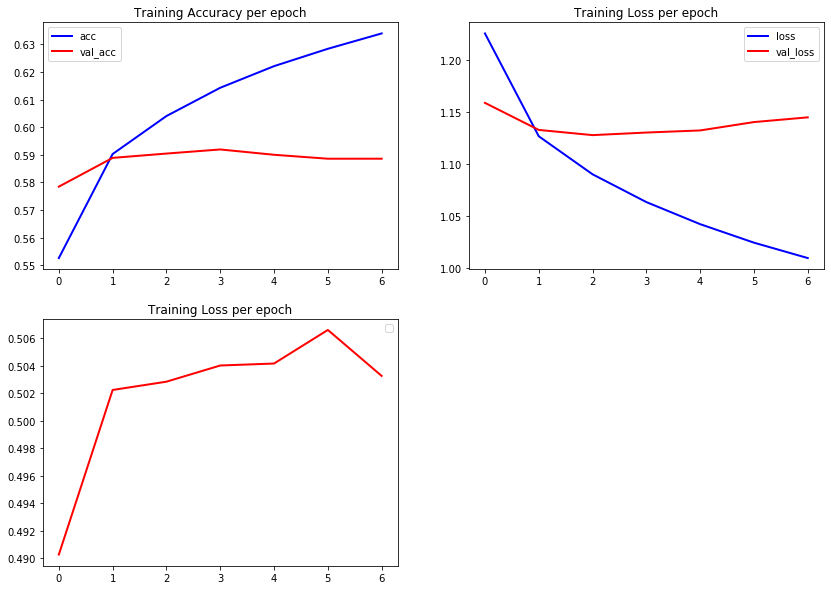

In [ ]:
plt.figure(figsize=(14, 10))

# plot training and validation accuracy per epoch
plt.subplot(221)
plt.plot('epoch', 'acc', data=training_log, marker='', color='b', linewidth=2)
plt.plot('epoch', 'val_acc', data=training_log , marker='', color='r', linewidth=2)

plt.title('Training Accuracy per epoch')
plt.legend()

# plot training and validation loss per epoch
plt.subplot(222)
plt.plot('epoch', 'loss', data=training_log, marker='', color='b', linewidth=2)
plt.plot('epoch', 'val_loss', data=training_log , marker='', color='r', linewidth=2)

plt.title('Training Loss per epoch')
plt.legend()

# plot validation macro fl score per epoch
plt.subplot(223)
index = np.arange(epochs)
plt.plot(index, metrics.val_f1s, marker='', color='r', linewidth=2)

plt.title('Training Loss per epoch')
plt.legend()

plt.show()  

#### Save model parameters

In [ ]:
model = RNN

In [ ]:
# save model
model_json = model.to_json()
with open("models/RNN_v3.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model.save_weights("models/RNN_v3.h5")
print("Saved model to disk")

Saved model to disk


---
---

### validation on test set

In [ ]:
model = RNN
df = test_df
batch_size = 32

In [ ]:
# data preparations
X_private_test = tokenizer.texts_to_sequences(df['p_text'].values)
X_private_test = pad_sequences(X_private_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('Shape of data tensor:', X_private_test.shape)

Shape of data tensor: (218335, 30)


In [ ]:
# generate predictions
Y_private_test_pred = model.predict(X_private_test, batch_size=batch_size)

In [ ]:
# correct labels
y_true = df['label'].values

# decode prediction results into labels
y_pred = label_decode(label_encoder, Y_private_test_pred)

In [ ]:
print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

       anger       0.62      0.27      0.37      5982
anticipation       0.64      0.62      0.63     37269
     disgust       0.47      0.42      0.44     20866
        fear       0.66      0.46      0.54      9447
         joy       0.62      0.78      0.69     77286
     sadness       0.47      0.58      0.52     29160
    surprise       0.70      0.25      0.37      7343
       trust       0.63      0.37      0.47     30982

    accuracy                           0.59    218335
   macro avg       0.60      0.47      0.50    218335
weighted avg       0.59      0.59      0.58    218335



---
---

### Generate Prediction on public test set

In [ ]:
# load json and create model
json_file = open('models/RNN.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights("models/RNN.h5")
print("Loaded model from disk")

In [ ]:
model = model
df = public_test_df
batch_size = 32

In [ ]:
# data preparations
X_public_test = tokenizer.texts_to_sequences(df['p_text'].values)
X_public_test = pad_sequences(X_public_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('Shape of data tensor:', X_public_test.shape)

Shape of data tensor: (411972, 30)


In [ ]:
# generate predictions
Y_public_test_pred = model.predict(X_public_test, batch_size=batch_size)

In [ ]:
# decode prediction results into labels
y_pred = label_decode(label_encoder, Y_public_test_pred)

In [ ]:
# transform into dataframe to submit to kaggle
sample_sub['emotion'] = y_pred
sample_sub.head()

,id,emotion
0,0x2c7743,joy
1,0x2c1eed,joy
2,0x2826ea,sadness
3,0x356d9a,joy
4,0x20fd95,joy


In [ ]:
sample_sub.to_csv('submission.csv', index=False)